In [1]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Train_path='../input/chest-xray-pneumonia/chest_xray/train' 
Test_path='../input/chest-xray-pneumonia/chest_xray/test' 

In [3]:
def load_Data(dir):
    Categories=['NORMAL','PNEUMONIA']
    X_arr=[]#input array
    Y_arr=[] #output array
    for i in Categories:
        dem=0
        print(f'loading... category : {i}')
        path=os.path.join(dir,i)
        for img in os.listdir(path):
            img_array=imread(os.path.join(path,img))
            img_resized=resize(img_array,(100,100,3))
            X_arr.append(img_resized.flatten()/255)
            Y_arr.append(Categories.index(i))
            if dem==1341:break 
            else :dem+=1
        print(f'loaded category:{i} successfully')
    print("Completed!")
    return X_arr,Y_arr

In [4]:
X_train,y_train=load_Data(Train_path)

loading... category : NORMAL
loaded category:NORMAL successfully
loading... category : PNEUMONIA
loaded category:PNEUMONIA successfully
Completed!


In [5]:
X_test,y_test=load_Data(Test_path)

loading... category : NORMAL
loaded category:NORMAL successfully
loading... category : PNEUMONIA
loaded category:PNEUMONIA successfully
Completed!


<BarContainer object of 2 artists>

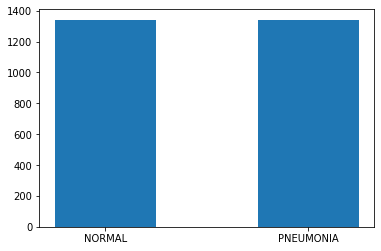

In [89]:
from collections import Counter
d=Counter(y_train)               
plt.bar(['NORMAL','PNEUMONIA'], d.values(),width=0.5)


# Extract image attributes

In [6]:

from sklearn.decomposition import PCA
pca = PCA()
X_new = pca.fit_transform(X_train)

In [7]:
explained_variance=pca.explained_variance_ratio_
len(explained_variance[explained_variance>0.0001])

373

In [12]:
from sklearn.decomposition import PCA
pca=PCA(n_components=373)
X_train=pca.fit_transform(X_train)

In [13]:
X_test=pca.transform(X_test)

# Traing Model

## SVM Model

In [ ]:
# from sklearn.svm import SVC
# from sklearn.model_selection import  GridSearchCV
# parameters={'C':[0.01,0.1,1,10],
#            'gamma': [1,0.1,0.001,0.0001]}
# clf = GridSearchCV(SVC(kernel='rbf' ), parameters)
# clf.fit(X_new,y_train)
# SVM_model = clf.best_estimator_
# print (clf.best_score_, clf.best_params_)

In [14]:
from sklearn.svm import SVC
clf_SVM=SVC(C=0.1,kernel='rbf' )
clf_SVM.fit(X_train,y_train)


SVC(C=0.1)

## Logistic Regression Model 

In [15]:
from sklearn.linear_model import LogisticRegression
LGR = LogisticRegression(solver='liblinear',C=1)
LGR.fit(X_train,y_train)

LogisticRegression(C=1, solver='liblinear')

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 
ABR= AdaBoostClassifier()
ABR.fit(X_train,y_train)

AdaBoostClassifier()

# Evaluate Model

In [56]:
test_path='../input/chest-xray-pneumonia/chest_xray/test'
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
model = models.load_model('../input/models/Diagnose_Pneumoinia.h5')
test_datagen=ImageDataGenerator(rescale = 1./255.0)
test_generator=test_datagen.flow_from_directory(
        test_path,
        target_size=(116,82),
        class_mode='binary',
        batch_size=32,
        shuffle=False)
y_pred = np.round(model.predict(test_generator))
y_true = test_generator.classes
y_labels = list(test_generator.class_indices.keys())

Found 624 images belonging to 2 classes.


In [17]:
from sklearn.metrics import classification_report, plot_confusion_matrix,plot_roc_curve
print (classification_report(y_train,clf_SVM.predict(X_train)))
print (classification_report(y_train,LGR.predict(X_train)))
print (classification_report(y_train,ABR.predict(X_train)))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1341
           1       0.95      0.96      0.96      1342

    accuracy                           0.96      2683
   macro avg       0.96      0.96      0.96      2683
weighted avg       0.96      0.96      0.96      2683

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1341
           1       0.89      0.88      0.89      1342

    accuracy                           0.89      2683
   macro avg       0.89      0.89      0.89      2683
weighted avg       0.89      0.89      0.89      2683

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1341
           1       0.96      0.96      0.96      1342

    accuracy                           0.96      2683
   macro avg       0.96      0.96      0.96      2683
weighted avg       0.96      0.96      0.96      2683



In [57]:
from sklearn.metrics import classification_report, plot_confusion_matrix,plot_roc_curve, accuracy_score,ConfusionMatrixDisplay
print (classification_report(y_test,clf_SVM.predict(X_test)))
print (classification_report(y_test,LGR.predict(X_test)))
print (classification_report(y_test,ABR.predict(X_test)))
print(classification_report(y_true, y_pred, target_names=y_labels))


              precision    recall  f1-score   support

           0       0.89      0.61      0.72       234
           1       0.80      0.96      0.87       390

    accuracy                           0.83       624
   macro avg       0.85      0.78      0.80       624
weighted avg       0.84      0.83      0.82       624

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       234
           1       0.86      0.87      0.87       390

    accuracy                           0.83       624
   macro avg       0.82      0.82      0.82       624
weighted avg       0.83      0.83      0.83       624

              precision    recall  f1-score   support

           0       0.87      0.57      0.69       234
           1       0.79      0.95      0.86       390

    accuracy                           0.81       624
   macro avg       0.83      0.76      0.78       624
weighted avg       0.82      0.81      0.80       624

              preci

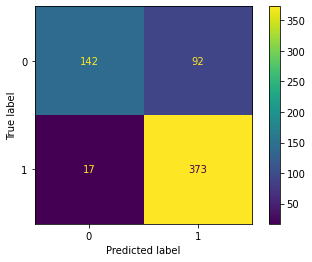

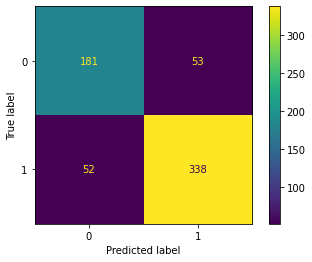

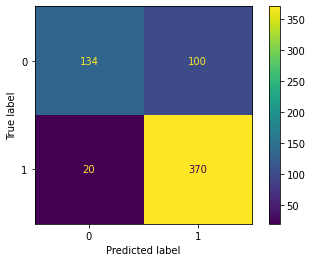

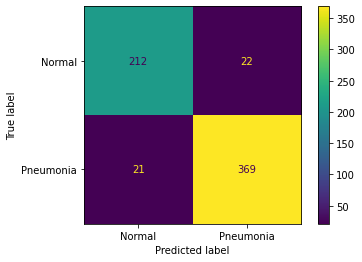

In [58]:
plot_confusion_matrix(clf_SVM,X_test,y_test)
plot_confusion_matrix(LGR,X_test,y_test)
plot_confusion_matrix(ABR,X_test,y_test)
display(ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['Normal', 'Pneumonia']).plot())

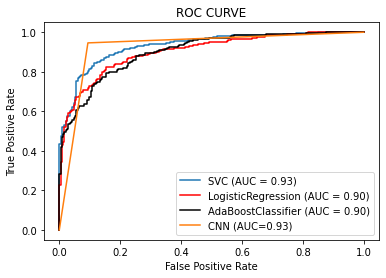

In [60]:
from sklearn.metrics import roc_auc_score,roc_curve
fpr, tpr, thresholds=metrics.roc_curve(y_true,y_pred)
auc_score=roc_auc_score(y_true,y_pred)
fig=plot_roc_curve(clf_SVM,X_test,y_test)
fig=plot_roc_curve(LGR,X_test,y_test,color='r',ax = fig.ax_)
fig=plot_roc_curve(ABR,X_test,y_test,color='black',ax = fig.ax_)
plt.plot(fpr, tpr, label='CNN (AUC='+str(round(auc_score,2))+")")
plt.legend()
plt.title("ROC CURVE")
plt.show()